<a href="https://colab.research.google.com/github/ML3ngiRNErT/funniness-regression/blob/main/task_1_main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Coursework coding instructions (please also see full coursework spec)

Please choose if you want to do either Task 1 or Task 2. You should write your report about one task only.

For the task you choose you will need to do two approaches:
  - Approach 1, which can use use pre-trained embeddings / models
  - Approach 2, which should not use any pre-trained embeddings or models
We should be able to run both approaches from the same colab file

#### Running your code:
  - Your models should run automatically when running your colab file without further intervention
  - For each task you should automatically output the performance of both models
  - Your code should automatically download any libraries required

#### Structure of your code:
  - You are expected to use the 'train', 'eval' and 'model_performance' functions, although you may edit these as required
  - Otherwise there are no restrictions on what you can do in your code

#### Documentation:
  - You are expected to produce a .README file summarising how you have approached both tasks

#### Reproducibility:
  - Your .README file should explain how to replicate the different experiments mentioned in your report

Good luck! We are really looking forward to seeing your reports and your model code!

In [1]:
# You will need to download any word embeddings required for your code, e.g.:
! pip install sacremoses
! pip install transformers
!wget http://nlp.stanford.edu/data/glove.6B.zip -P data/
!unzip data/glove.6B.zip -d data/


     |████████████████████████████████| 890kB 5.5MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp37-none-any.whl size=893262 sha256=5b2797af414079ec16672492b03e581c502008b33bdb7be6e0abba9d3ca7c011
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses
     |████████████████████████████████| 1.9MB 5.4MB/s 
     |████████████████████████████████| 3.2MB 12.8MB/s 
--2021-03-03 22:45:03--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2021-03-03 22:45:03--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanen

In [2]:
# For any packages that Colab does not provide auotmatically you will also need to install these below, e.g.:

! pip install ipympl
! pip install torch
! pip install swifter
!wget https://cs.rochester.edu/u/nhossain/semeval-2020-task-7-dataset.zip -P data/
!unzip data/semeval-2020-task-7-dataset.zip
! python -m spacy download en

     |████████████████████████████████| 112kB 4.2MB/s 
     |████████████████████████████████| 634kB 4.0MB/s 
     |████████████████████████████████| 296kB 17.1MB/s 
     |████████████████████████████████| 573kB 21.7MB/s 
     |████████████████████████████████| 112kB 35.6MB/s 
     |████████████████████████████████| 17.2MB 253kB/s 
     |████████████████████████████████| 47.5MB 135kB/s 
     |████████████████████████████████| 133kB 45.9MB/s 
     |████████████████████████████████| 81kB 8.4MB/s 
     |████████████████████████████████| 3.2MB 30.9MB/s 
     |████████████████████████████████| 81kB 7.8MB/s 
     |████████████████████████████████| 1.3MB 48.2MB/s 
     |████████████████████████████████| 204kB 51.3MB/s 
     |████████████████████████████████| 71kB 8.1MB/s 
     |████████████████████████████████| 143kB 47.3MB/s 
     |████████████████████████████████| 296kB 43.8MB/s 
     |████████████████████████████████| 71kB 8.2MB/s 
  Created wheel for swifter: filename=swifter-1.0.7-cp37-n

In [14]:
# Imports

import torch
import torch.nn.functional as F
import re 
import matplotlib.pyplot as plt
import seaborn as sns
import torch.nn as nn
import pandas as pd
import numpy as np
import spacy
import string
from sklearn.feature_extraction.text import CountVectorizer
from torch.utils.data import Dataset, random_split
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
import codecs
from transformers import AutoTokenizer, AutoModelForTokenClassification, pipeline
from tqdm.notebook import tqdm_notebook
from tqdm import tqdm
from collections import defaultdict
tqdm_notebook.pandas()


/usr/local/lib/python3.7/dist-packages/tqdm/std.py:658: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


In [4]:
# Setting random seed and device
SEED = 1

torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")
print(device)

cpu


In [8]:
# Load data
dir = 'semeval-2020-task-7-dataset/subtask-1'
train_df = pd.read_csv(f'{dir}/train.csv')
funlines_df = pd.read_csv(f'{dir}/train_funlines.csv')
test_df = pd.read_csv(f'{dir}/dev.csv')
all_headlines = list(train_df['original']) + list(funlines_df['original'])

embeddings_dict = {}
with open("data/glove.6B.50d.txt", 'r') as f:
    for line in f:
        values = line.split()
        word = values[0]
        vector = np.asarray(values[1:], "float32")
        embeddings_dict[word] = vector

## Named Entity Recognition
Casing of headlines makes traditional NER harder, train a statistical true caser then give to bert uncased model / use spacy NER

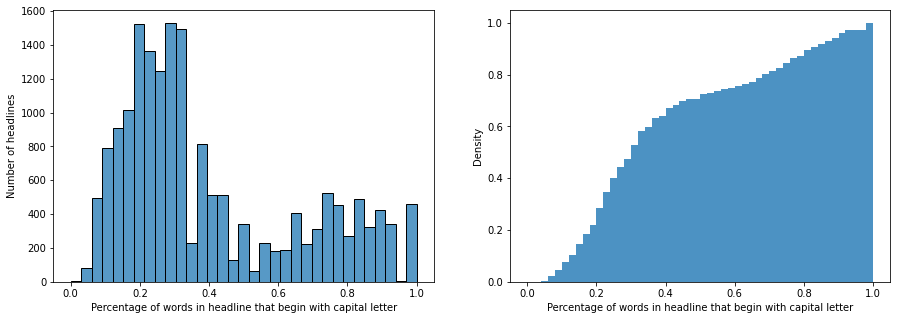

In [9]:
upperalpha = set('ABCDEFGHIJKLMNOPQRSTUVWXYZ')
punctuation = string.punctuation + "‘’”“’'/-\\."
hasCap = lambda x: (x[0] in upperalpha) or x[0].isdigit() if len(x) > 0 else False
def percentageCap(sentence):
    cleaned = re.sub(r"<(.*)\/>", "\g<1>", sentence).strip(punctuation).split(' ')
    return (len([w for w in cleaned if hasCap(w)]) / len(cleaned), ' '.join(cleaned))

cap_headlines = np.array([percentageCap(h) for h in all_headlines])
fig, ax =plt.subplots(1,2, figsize=(15,5))
caps = cap_headlines[:,0].astype(float)

sns.histplot(caps, ax=ax[0])
ax[0].set(xlabel='Percentage of words in headline that begin with capital letter', ylabel='Number of headlines')

ax[1].set_xlabel('Percentage of words in headline that begin with capital letter')
ax[1].set_ylabel('Density')
ax[1]=plt.hist(caps,cumulative=True, density=True, bins=50, alpha=0.8)
plt.show()

In [10]:
from sacremoses import MosesTruecaser, MosesTokenizer
headlines_less_than = lambda limit: cap_headlines[caps < limit][:,1] 
headlines_more_than = lambda limit: cap_headlines[caps > limit][:,1] 

mtr = MosesTruecaser()
mtok = MosesTokenizer(lang='en')
tokenized_docs = [mtok.tokenize(line) for line in headlines_less_than(0.45)]
truecase_results = mtr.train(tokenized_docs, save_to='big.truecasemodel')

In [11]:

def truecase(headline):
    s = mtr.truecase(headline.lower(), return_str=True)
    return s

truecase(np.random.choice(headlines_more_than(0.8)))

'Giuliani provides details of what trump knew about ambassador ’s removal'

In [12]:
tokenizer = AutoTokenizer.from_pretrained("dslim/bert-base-NER-uncased")
model = AutoModelForTokenClassification.from_pretrained("dslim/bert-base-NER-uncased")
# ! python -m spacy download en_core_web_lg
# nlp = spacy.load('en_core_web_lg')


In [17]:
from spacy.pipeline import EntityRuler
class EntityTagger:
    def __init__(self, use_bert=False):
        if use_bert:
            self.nlp = pipeline("ner", model=model, tokenizer=tokenizer, device=0)
        else:
            self.nlp = spacy.load("en_core_web_sm")
            ruler = self.nlp.create_pipe("entity_ruler")
            self.nlp.add_pipe(ruler)
            ruler.add_patterns([
                {"label": "PERSON", "pattern": "Trump"},
                {"label": "PERSON", "pattern": "trump"}
            ])
        self.use_bert = use_bert
    
    def _next_word_is_connected(self, results, i):
        return (i < len(results) - 1) and \
                results[i+1]['word'].startswith('##') and \
                results[i]['end'] == results[i+1]['start'] \
        
    def _process_results(self, results):
        if not results:
            return []
        words = []
        cur_word = ""
        cur_start = results[0]['start']
        for i, r in enumerate(results):
            cur_word += re.sub("##(.*)", "\g<1>", r['word'])
            if not self._next_word_is_connected(results, i):
                words.append(dict(word=cur_word, type=r['entity'][2::], start=cur_start, end=r['end']))
                cur_word = ""
                cur_start = results[i+1]['start'] if i < len(results) - 1 else results[i]['start']
            
        return words
    
    def _process_spacy_results(self, results):
        if results.ents:
            return [dict(word=r.text.lower(), type=r.label_) for r in results.ents]
        return []
            
    def tag(self, text):
        tc = truecase(text)
        results = self.nlp(tc)
        if self.use_bert:
            return self._process_results(results)
        else:
            return self._process_spacy_results(results)

tagger = EntityTagger(use_bert=False)
# example = "Visa , Mastercard , Stripe , and eBay all quit Facebook ’s Libra in one day"
example = np.random.choice(headlines_more_than(0.7))
# example = "Donald trump refuses to send more aid to Puerto Rico , citing business interests"
        
tagger.tag(example)

[{'type': 'ORG', 'word': 'house'},
 {'type': 'NORP', 'word': 'democrats'},
 {'type': 'PERSON', 'word': 'mueller'},
 {'type': 'PERSON', 'word': 'trump'}]

In [18]:
import spacy
from spacy.lang.en import English
nlp = spacy.load('en_core_web_sm')
class PreProcessor():
    def __init__(self, remove_stops=False, lowercase=False, lemmatize=False, replace_edit=False):
        self.remove_stops = remove_stops
        self.lowercase = lowercase
        self.lemmatize = lemmatize
        self.replace_edit = replace_edit
    
    def process(self,row): 
        e, o = row['edit'], row['original']
        if self.replace_edit:
            replaced = re.sub(r"<(.*)\/>", r"\g<1>", row['original'])
        else:
            replaced = re.sub(r"<(.*)\/>", e, o)
        
        replaced = replaced.translate(str.maketrans('','', punctuation))
        if self.lowercase:
            replaced = replaced.lower()
        doc = nlp(replaced)
        doc = [t for t in doc if t.text not in punctuation]
        doc = [t for t in doc if not t.is_space] # Remove space tokens
        if self.remove_stops:
            doc = [t for t in doc if not (t.is_stop and t.text != e)] # Ensure edits aren't removed if they are stop words
        if self.lemmatize:
            st = " ".join([t.lemma_ for t in doc])
        else:
            st = " ".join([t.text for t in doc])
            
        return st
# PreProcessor(remove_stops=True, lowercase=True, lemmatize=True) \
#     .process(dict(original="Trump announces ' precision strikes ' on Syria , decries ' <monster/> ' Assad"))

In [19]:
preprocessor = PreProcessor(remove_stops=False)
train_df['cleaned'] = train_df.progress_apply(preprocessor.process, axis=1)
train_df['entity_tags'] = train_df.progress_apply(lambda x: tagger.tag(x['cleaned']), axis=1)


In [20]:
def get_unique_entities(threshold=8):
    unique = defaultdict(lambda: defaultdict(int))
    for i, entities in enumerate(train_df['entity_tags']):
        for e in entities:
            unique[e['type']][e['word']] += 1
    
    thresholded = defaultdict(lambda: defaultdict(int))
    for k, v in unique.items():
        for ent, count in v.items():
            if count >= threshold:
                thresholded[k][ent] = count
    
    return thresholded
entities = get_unique_entities()

Text(0, 0.5, 'Occurences')

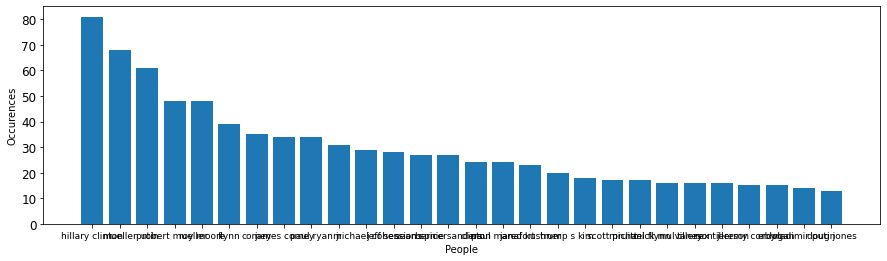

In [21]:
names = np.array(sorted(entities['PERSON'].items(), key=lambda x: x[1])[::-1])
counts = names[:,1].astype(int)
# for i, c in enumerate(counts):
#     print(f"{names[i][0]} - {c * 100 / sum(counts):.2f}%")
fig = plt.figure(figsize=(15,4))
plt.bar(names[:,0][2:30],counts[2:30])
fig.axes[0].tick_params(axis="x", labelsize=9)
fig.axes[0].tick_params(axis="y", labelsize=12)
fig.axes[0].set_xlabel("People")
fig.axes[0].set_ylabel("Occurences")

In [22]:
train_df['cleaned_no_stops'] = train_df.progress_apply(PreProcessor(remove_stops=True, lowercase=True, lemmatize=True).process, axis=1)

In [23]:
train_df['cleaned_replaced'] = train_df.progress_apply(PreProcessor(remove_stops=True, lowercase=True, lemmatize=True, replace_edit=True).process, axis=1)

In [24]:
def all_entities():
    all_entities = set()
    for k in entities.keys():
        for e in entities[k]:
            all_entities.add(e)
    return all_entities

def getNearbyWords():
    nearby_words = defaultdict(set)
    counts = defaultdict(int)
    for i, w in tqdm(enumerate(train_df['cleaned_no_stops'])):
        tags = train_df.iloc[i]['entity_tags']
        edit = nlp(train_df.iloc[i]['edit'].lower())[0].lemma_
        ents_in_headline = set(tag['word'] for tag in tags)
        nearby = set(w.split(' ')) - ents_in_headline
        for w in ents_in_headline:
            for n in nearby:
                counts[(w,n)] += train_df.iloc[i]['meanGrade']**3
            nearby_words[w] |= nearby
        nearby_words[w].add(edit)
        counts[(w,edit)] += train_df.iloc[i]['meanGrade']**3
    return nearby_words, counts

all_entities = all_entities()
nearby_words, counts = getNearbyWords()

9652it [01:42, 93.81it/s]


In [25]:
%matplotlib widget

from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D
from sklearn.cluster import KMeans

sns.set_style("whitegrid", {'axes.grid' : False})

def getEmbs(ent, three_dims=False, topn=20, plot=False):
    if ent not in nearby_words:
        print("Not valid ent")
        return
    words_to_plot = [w for w in nearby_words[ent] if w in embeddings_dict]
    if not words_to_plot:
        print("No words to plot")
        return
    words_to_plot = sorted(words_to_plot, key=lambda w: -counts[(ent, w)])[:topn]
    vectors = np.array([embeddings_dict[w] for w in words_to_plot])
    if plot:
        fig, ax = plt.subplots()
        points = PCA(random_state=0).fit_transform(vectors)[:,:3]

        if three_dims:
            ax = Axes3D(fig)
            ax.scatter(points[:,0], points[:,1], points[:,2])
            for i, txt in enumerate(words_to_plot):
                ax.text(points[i,0], points[i,1], points[i,2], txt)
        else:
            ax.scatter(points[:,0], points[:,1])
            for i, txt in enumerate(words_to_plot):
                ax.annotate(txt, (points[i,0], points[i,1]))
        plt.show()
    return words_to_plot, vectors
    

100%|██████████| 306/306 [00:06<00:00, 50.13it/s]


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

array([[-5.09639904e-02,  2.62967944e-01,  3.94591987e-01,
        -1.08817801e-01,  6.34020120e-02,  3.47998023e-01,
        -5.86169958e-01, -9.26139951e-03, -3.83967996e-01,
        -8.23374033e-01, -1.33165789e+00, -5.25969982e-01,
        -2.16880411e-01,  1.36165991e-01,  2.56153941e-02,
        -3.44287992e-01, -1.10933997e-01, -1.60580009e-01,
         4.75669444e-01, -8.44693780e-02, -1.50513938e-02,
         3.00771952e-01,  3.89463991e-01, -3.12619984e-01,
         2.48516649e-01, -2.01945996e+00, -8.23799968e-02,
         1.04842007e-01, -5.21629989e-01,  2.71788031e-01,
         1.75732005e+00,  3.74246001e-01, -1.15410197e+00,
        -5.03906608e-01, -6.28397942e-01, -4.45547789e-01,
        -4.14158583e-01,  2.04464003e-01, -6.53676033e-01,
        -8.38564038e-01, -2.86634028e-01,  3.00244004e-01,
        -7.51446009e-01, -1.18026614e-01,  7.33857974e-02,
        -3.03552449e-01, -8.20562005e-01,  1.24383807e-01,
         1.68525189e-01,  3.91465962e-01],
       [ 7.06

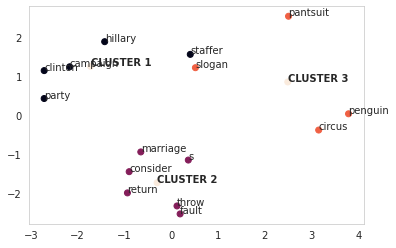

In [30]:
def getClusterVectors(ent, plot=False, n_clusters=3, topn=50):
    words, vectors = getEmbs(ent, topn=topn)
    kmeans = KMeans(n_clusters=n_clusters, random_state=0).fit(vectors)
    if plot:
        points = PCA(random_state=0).fit_transform(np.concatenate((vectors,kmeans.cluster_centers_)))[:,:3]
        cluster_colours = np.repeat(n_clusters, n_clusters)
        colours = np.concatenate((kmeans.labels_, cluster_colours))
        fig, ax = plt.subplots()
        ax.scatter(points[:,0], points[:,1], c=colours)
        for i, txt in enumerate(words + [f'CLUSTER {i+1}' for i in range(n_clusters)]):
            kwargs = {}
            if 'CLUSTER ' in txt:
                kwargs = {'weight': 'bold'}
            ax.annotate(txt, (points[i,0], points[i,1]), **kwargs)
        plt.show()
    return kmeans.cluster_centers_

entity_clusters = {ent: getClusterVectors(ent, n_clusters=2, topn=10) for ent in tqdm(all_entities)}
getClusterVectors('hillary clinton', plot=True, topn=15)


# Collect features

In [31]:

def position_of_edit(row):
    words = row['original'].split(' ')
    count = 0
    for w in words:
        if re.match("<.*\/>", w):
            return count
        count += 1
    return 1

def len_headline(row):
    return len(row['original'].split(' '))
    
def funniness_of_each_entity():
    funniness = defaultdict(float)
    counts = defaultdict(int)
    for i, ents in tqdm(enumerate(train_df['entity_tags'])):
        for ent in ents:
            funniness[ent['word']] += train_df.iloc[i]['meanGrade']
            counts[ent['word']] += 1
            
    avg_funniness = dict()
    for k, v in funniness.items():
        avg_funniness[k] = funniness[k] / counts[k]
    
    return avg_funniness
        
train_df['edit_pos'] = train_df.progress_apply(position_of_edit, axis=1)
train_df['len'] = train_df.progress_apply(len_headline, axis=1)

In [32]:
#  sorted(list(entity_funniness.items()), key=lambda x: -entity_funniness[x[0]])
entity_funniness = funniness_of_each_entity()

9652it [00:02, 3609.79it/s]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in power


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

0.1390163984430042

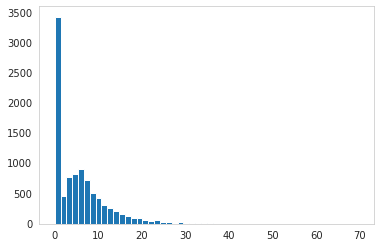

In [33]:
def similarity(a, b):
    return np.dot(a, b)/(np.linalg.norm(a)*np.linalg.norm(b))

def get_max_similarity(vec, clusters):
    return np.max([similarity(vec, c) for c in clusters])

def entity_funniness_score(row): 
    r = row['cleaned_replaced']
    relevant_entities = [x['word'] for x in row['entity_tags'] if (x['word'] in entity_funniness) and (x['word'] in entity_clusters)]
    score = 0
    for w in r.split(' '):
        if w not in embeddings_dict or w in relevant_entities:
            continue
        vec = embeddings_dict[w]
        for ent in relevant_entities:
#             if not (ent in entities['PER'] or ent in entities['LOC']):
#                 continue
            clusters = entity_clusters[ent]
            max_sim = get_max_similarity(vec, clusters)
            score += (max_sim ** 0.25) * entity_funniness[ent] ** 3
    return score
    
train_df['entity_funniness_score'] = train_df.progress_apply(entity_funniness_score, axis=1)
train_df['entity_funniness_score'].fillna(0, inplace=True)
fig, ax = plt.subplots()
ax.hist(train_df['entity_funniness_score'].to_numpy(), bins=52)
plt.show()
train_df['entity_funniness_score'].corr(train_df['meanGrade'])

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

-0.15680708656808165

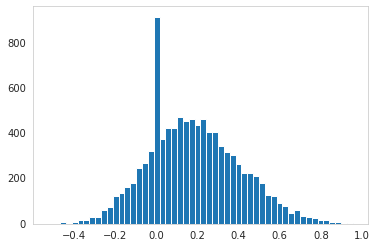

In [34]:
def distance_of_edit_to_original(row):
#     return np.random.randint(100) * 0.01
    e = row['edit'].lower()
    original = re.search('<(.*)\/>', row['original']).group(1).lower()
    if original in embeddings_dict and e in embeddings_dict:
        return similarity(embeddings_dict[e], embeddings_dict[original])
    return 0

train_df['edit_similarity'] = train_df.progress_apply(distance_of_edit_to_original, axis=1)
fig, ax = plt.subplots()
ax.hist(train_df['edit_similarity'].to_numpy(), bins=52)
plt.show()
train_df['edit_similarity'].corr(train_df['meanGrade'])

In [35]:
train_df.head()

,id,original,edit,grades,meanGrade,cleaned,entity_tags,cleaned_no_stops,cleaned_replaced,edit_pos,len,entity_funniness_score,edit_similarity
0,14530,France is ‘ hunting down its citizens who join...,twins,10000,0.2,France is hunting down its citizens who joined...,"[{'word': 'france', 'type': 'GPE'}, {'word': '...",france hunt citizen join twin trial iraq,france hunt citizen join isis trial iraq,9,15,5.103463,0.064800
1,13034,"Pentagon claims 2,000 % increase in Russian tr...",bowling,33110,1.6,Pentagon claims 2000 increase in Russian troll...,"[{'word': 'pentagon', 'type': 'ORG'}, {'word':...",pentagon claim 2000 increase russian troll bow...,pentagon claim 2000 increase russian troll syr...,9,17,0.000000,-0.019825
2,8731,Iceland PM Calls Snap Vote as Pedophile Furor ...,party,22100,1.0,Iceland PM Calls Snap Vote as Pedophile Furor ...,"[{'word': 'iceland', 'type': 'GPE'}, {'word': ...",iceland pm call snap vote pedophile furor cras...,iceland pm call snap vote pedophile furor cras...,9,11,0.000000,0.830763
3,76,"In an apparent first , Iran and Israel <engage...",slap,20000,0.4,In an apparent first Iran and Israel slap each...,"[{'word': 'first', 'type': 'ORDINAL'}, {'word'...",apparent iran israel slap militarily,apparent iran israel engage militarily,8,12,5.016168,0.169812
4,6164,Trump was told weeks ago that Flynn misled <Vi...,school,0,0.0,Trump was told weeks ago that Flynn misled sch...,"[{'word': 'trump', 'type': 'PERSON'}, {'word':...",trump tell week ago flynn mislead school presi...,trump tell week ago flynn mislead vice president,8,11,9.996328,0.384219


# Train neural net

In [36]:
test_df['cleaned'] = test_df.progress_apply(preprocessor.process, axis=1)
test_df['entity_tags'] = test_df.progress_apply(lambda x: tagger.tag(x['cleaned']), axis=1)
test_df['cleaned_no_stops'] = test_df.progress_apply(PreProcessor(remove_stops=True, lowercase=True, lemmatize=True).process, axis=1)
test_df['cleaned_replaced'] = test_df.progress_apply(PreProcessor(remove_stops=True, lowercase=True, lemmatize=True, replace_edit=True).process, axis=1)
test_df['entity_funniness_score'] = test_df.progress_apply(entity_funniness_score, axis=1)
test_df['entity_funniness_score'].fillna(0, inplace=True)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in power


In [37]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(1, 100)  
        self.fc2 = nn.Linear(100, 100)  
        self.fc3 = nn.Linear(100, 1)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.sigmoid(self.fc3(x))
        return x * 4

In [38]:
net = Net().to(device)
# cols = ['edit_pos', 'len', 'edit_similarity', 'entity_funniness_score']
cols = ['entity_funniness_score']
training_data, dev_data, training_y, dev_y = train_test_split(train_df[cols], train_df['meanGrade'], test_size=0.1, random_state=42)
train_X = torch.tensor(training_data.to_numpy()).float()
val_X = torch.tensor(dev_data.to_numpy()).float()
train_y = torch.tensor(training_y.to_numpy()).float()
val_y = torch.tensor(dev_y.to_numpy()).float()
test_X = torch.tensor(test_df[cols].to_numpy()).float()
test_y = torch.tensor(test_df['meanGrade'].to_numpy()).float()

train_ds = torch.utils.data.TensorDataset(train_X, train_y)
val_ds = torch.utils.data.TensorDataset(val_X, val_y)
test_ds = torch.utils.data.TensorDataset(test_X, test_y)

train_loader = torch.utils.data.DataLoader(train_ds, batch_size=8)
val_loader = torch.utils.data.DataLoader(val_ds, batch_size=8)
test_loader = torch.utils.data.DataLoader(test_ds, batch_size=8)

loss_fn = nn.MSELoss()
loss_fn = loss_fn.to(device)
optimizer = torch.optim.Adam(net.parameters(), lr=0.001)

def train(epochs=40):
    train_losses = []
    val_losses = []
    for e in range(epochs):
        train_loss = 0
        for batch_idx, (X, y) in enumerate(train_loader):
            X, y = X.to(device), y.to(device)
            optimizer.zero_grad()
            pred = net(X).squeeze(1)
            loss = loss_fn(pred, y)
            train_loss += loss.item()
            loss.backward()
            optimizer.step()
            
        with torch.no_grad():
            val_loss = 0
            for batch_idx, (X, y) in enumerate(test_loader):
                X, y = X.to(device), y.to(device)
                pred = net(X)
                loss = loss_fn(pred, y)
                val_loss += loss.item()
            vl = val_loss / len(test_loader)
            val_losses.append(vl)
            
        tl = train_loss / len(train_loader)
        train_losses.append(tl)
        print(f"Epoch {e:<3} - TL : {tl:.3f} | TRAIN RMSE: {np.sqrt(tl):.3f} | VL : {vl:.3f} | VAL RMSE : {np.sqrt(vl):.3f}")
    return train_losses, val_losses
tl, vl = train()

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1639: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:446: UserWarning: Using a target size (torch.Size([8])) that is different to the input size (torch.Size([8, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:446: UserWarning: Using a target size (torch.Size([3])) that is different to the input size (torch.Size([3, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 0   - TL : 0.375 | TRAIN RMSE: 0.613 | VL : 0.359 | VAL RMSE : 0.599
Epoch 1   - TL : 0.350 | TRAIN RMSE: 0.591 | VL : 0.348 | VAL RMSE : 0.590
Epoch 2   - TL : 0.344 | TRAIN RMSE: 0.586 | VL : 0.347 | VAL RMSE : 0.589
Epoch 3   - TL : 0.342 | TRAIN RMSE: 0.585 | VL : 0.346 | VAL RMSE : 0.589
Epoch 4   - TL : 0.342 | TRAIN RMSE: 0.585 | VL : 0.349 | VAL RMSE : 0.590
Epoch 5   - TL : 0.340 | TRAIN RMSE: 0.583 | VL : 0.349 | VAL RMSE : 0.591
Epoch 6   - TL : 0.339 | TRAIN RMSE: 0.583 | VL : 0.346 | VAL RMSE : 0.589
Epoch 7   - TL : 0.339 | TRAIN RMSE: 0.582 | VL : 0.347 | VAL RMSE : 0.589
Epoch 8   - TL : 0.338 | TRAIN RMSE: 0.581 | VL : 0.345 | VAL RMSE : 0.587
Epoch 9   - TL : 0.337 | TRAIN RMSE: 0.581 | VL : 0.345 | VAL RMSE : 0.587
Epoch 10  - TL : 0.337 | TRAIN RMSE: 0.581 | VL : 0.346 | VAL RMSE : 0.588
Epoch 11  - TL : 0.337 | TRAIN RMSE: 0.580 | VL : 0.345 | VAL RMSE : 0.588
Epoch 12  - TL : 0.336 | TRAIN RMSE: 0.580 | VL : 0.344 | VAL RMSE : 0.587
Epoch 13  - TL : 0.336 | 

In [39]:
net.eval()
with torch.no_grad():
    test_loss = 0
    for batch_idx, (X, y) in enumerate(test_loader):
        X, y = X.to(device), y.to(device)
        pred = net(X)
        loss = loss_fn(pred, y)
        test_loss += loss.item()
    test_loss = test_loss / len(test_loader)

np.sqrt(test_loss)

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1639: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:446: UserWarning: Using a target size (torch.Size([8])) that is different to the input size (torch.Size([8, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:446: UserWarning: Using a target size (torch.Size([3])) that is different to the input size (torch.Size([3, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


0.5834365750315923

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

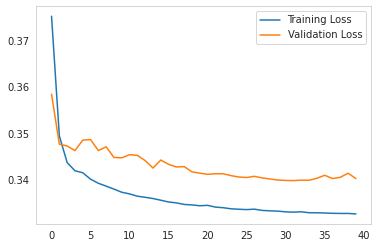

In [40]:
fig, ax = plt.subplots()
ax.plot(tl, label="Training Loss")
ax.plot(vl, label="Validation Loss")
plt.legend()

In [41]:
print(np.mean([np.sqrt(x) for x in tl]))
print(np.mean([np.sqrt(x) for x in vl]))

0.580310253756714
0.5858470121785837
